# Hyperspectral Image Classification


In [1]:
import os
import random
import itertools
from random import shuffle
import h5py
import json

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage 
from skimage.transform import rotate 
import spectral # Module for processing hyperspectral image data.
import matplotlib 
%matplotlib inline

# scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.models import load_model
K.set_image_dim_ordering('th')
from keras.utils import np_utils


Using TensorFlow backend.
/home/ali/anaconda2/envs/mypython3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ali/anaconda2/envs/mypython3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ali/anaconda2/envs/mypython3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ali/anaconda2/

## Dataset Loading  and Preproccesing



In [2]:
def  load_dataset(dataset):
    """load dataset parameters from config.json"""
    
    with open('./config.json') as f:
        config = json.loads(f.read())
        params = config[dataset]
        data = sio.loadmat(params['img_path'])[params['img']]
        labels = sio.loadmat(params['gt_path'])[params['gt']]
        num_classes = params['num_classes']
        target_names = params['target_names']
        
    return data,labels,num_classes,target_names
        

In [3]:
def apply_pca(X, num_components=75):
    """apply pca to X and return new_X"""
    
    new_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_X = pca.fit_transform(new_X)
    new_X = np.reshape(new_X, (X.shape[0],X.shape[1], num_components))
    return new_X, pca

In [4]:
def pad_with_zeros(X, margin=2):
    """apply zero padding to X with margin"""
    
    new_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    new_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return new_X


In [5]:
def create_patches(X, y, window_size=5, remove_zero_labels = True):
    """create patch from image. suppose the image has the shape (w,h,c) then the patch shape is
    (w*h,window_size,window_size,c)"""
    
    margin = int((window_size - 1) / 2)
    zero_padded_X = pad_with_zeros(X, margin=margin)
    # split patches
    patches_data = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchs_labels = np.zeros((X.shape[0] * X.shape[1]))
    patch_index = 0
    for r in range(margin, zero_padded_X.shape[0] - margin):
        for c in range(margin, zero_padded_X.shape[1] - margin):
            patch = zero_padded_X[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patches_data[patch_index, :, :, :] = patch
            patchs_labels[patch_index] = y[r-margin, c-margin]
            patch_index = patch_index + 1
    if remove_zero_labels:
        patches_data = patches_data[patchs_labels>0,:,:,:]
        patchs_labels = patchs_labels[patchs_labels>0]
        patchs_labels -= 1
    return patches_data, patchs_labels

In [6]:
def split_train_test_set(X, y, test_ratio=0.10):
    """split dataset into train set and test set with test_ratio"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [7]:
def oversample_weak_classes(X, y):
    """"balance the dataset by prforming oversample of weak classes (making each class have close labels_counts)"""
    unique_labels, labels_counts = np.unique(y, return_counts=True)
    
    print(unique_labels.shape)
    print(unique_labels)
    print(labels_counts.shape)
    print(labels_counts)
    max_count = np.max(labels_counts)
    labels_inverse_ratios = max_count / labels_counts  
    #print(labels_inverse_ratios)
    # repeat for every label and concat
    print(labels_inverse_ratios)
    new_X = X[y == unique_labels[0], :, :, :].repeat(round(labels_inverse_ratios[0]), axis=0)
    new_Y = y[y == unique_labels[0]].repeat(round(labels_inverse_ratios[0]), axis=0)
    for label, labelInverseRatio in zip(unique_labels[1:], labels_inverse_ratios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        new_X = np.concatenate((new_X, cX))
        new_Y = np.concatenate((new_Y, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(new_Y.shape[0])
    new_X = new_X[rand_perm, :, :, :]
    new_Y = new_Y[rand_perm]
    unique_labels, labels_counts = np.unique(new_Y, return_counts=True)
    
#     print(unique_labels.shape)
#     print(unique_labels)
#     print(labels_counts.shape)
#     print(labels_counts)
    return new_X, new_Y


In [8]:
def augment_data(X_train):
    """augment the data by taking each patch and randomly performing 
    a flip(up/down or right/left) or a rotation"""
    
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2
    
    return X_train

In [9]:
#Parameters
dataset = "PaviaU" # Indian_pines or PaviaU or or Salinas  . check config.json
window_size = 5
num_pca_components = 30
test_ratio = 0.25

### Preproccesing steps
<img src="./images/1.png" alt="diagram">

In [10]:
X, y , num_classes , target_names = load_dataset(dataset)

X,pca = apply_pca(X,num_pca_components)

X_patches, y_patches = create_patches(X, y, window_size=window_size)

X_train, X_test, y_train, y_test = split_train_test_set(X_patches, y_patches, test_ratio)

X_train, y_train = oversample_weak_classes(X_train, y_train)

X_train = augment_data(X_train)


y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_test)


(9,)
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
(9,)
[ 4973 13987  1574  2298  1009  3772   998  2761   710]
[ 2.81258798  1.          8.886277    6.08659704 13.86223984  3.70811241
 14.01503006  5.06591815 19.7       ]


## Defining and Training the model

In [12]:
def define_model() :
    
    
    input_shape= X_train[0].shape # Define the input shape 
    C1 = 3*num_pca_components # number of filters
    
    model = Sequential()
    model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(3*C1, (3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6*num_pca_components, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [24]:
model = define_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 90, 3, 28)         4140      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 270, 1, 26)        218970    
_________________________________________________________________
dropout_3 (Dropout)          (None, 270, 1, 26)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7020)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 180)               1263780   
_________________________________________________________________
dropout_4 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 1629      
Total para

In [ ]:
# We have already trained the model
model.fit(X_train, y_train, batch_size=32, epochs=15)

In [ ]:
model.save('./saved_models/model_{}_{}_{}_{}.h5'.format(dataset,window_size,num_pca_components,test_ratio))

## Model Validation

In [25]:
model = load_model('./saved_models/model_{}_{}_{}_{}.h5'.format(dataset,window_size,num_pca_components,test_ratio))

In [15]:
def generate_report (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    test_Loss =  score[0]*100
    test_accuracy = score[1]*100
    
    return classification, confusion, test_Loss, test_accuracy


In [16]:
def show_report(classification, confusion, test_loss, test_accuracy) :
    
    classification = str(classification)
    confusion = str(confusion)

    report = '{} Test loss (%)'.format(test_loss)
    report += '\n'
    report += '{} Test accuracy (%)'.format(test_accuracy)
    report += '\n'
    report += '\n'
    report += '{}'.format(classification)
    report += '\n'
    report += '{}'.format(confusion)
    print(report)
    
    return report
    

In [17]:
def save_report(report):
    file_name = 'report_{}_{}_{}_{}.txt'.format(dataset,window_size,num_pca_components,test_ratio)
    with open('./reports/{}'.format(file_name), 'w') as report_file:
        report_file.write(report)
        print("\n\nReport saved to {}".format(file_name))
    return 
    

In [18]:
def get_patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [26]:
# Using the pretrained model make predictions and print the results into a reportclassification, confusion, test_loss, test_accuracy = generate_report(X_test,y_test)

classification, confusion, test_Loss, test_accuracy = generate_report(X_test,y_test)
report = show_report(classification, confusion, test_Loss, test_accuracy)
save_report(report)


10694/10694 [==============================] - 9s 876us/step
2.337692957388891 Test loss (%)
99.31737422853936 Test accuracy (%)

                      precision    recall  f1-score   support

             Asphalt       1.00      0.99      0.99      1658
             Meadows       1.00      1.00      1.00      4662
              Gravel       0.97      0.96      0.97       525
               Trees       0.99      1.00      1.00       766
Painted metal sheets       1.00      1.00      1.00       336
           Bare Soil       0.99      1.00      0.99      1257
             Bitumen       0.99      1.00      0.99       332
Self-Blocking Bricks       0.97      0.98      0.98       921
             Shadows       1.00      1.00      1.00       237

            accuracy                           0.99     10694
           macro avg       0.99      0.99      0.99     10694
        weighted avg       0.99      0.99      0.99     10694

[[1644    0    1    0    0    0    5    8    0]
 [   0 4644  

## Building the Classification Maps

In [27]:
# load the original image
dataset="PaviaU"
X, y , num_classes,target_names= load_dataset(dataset)
X,pca = apply_pca(X,num_pca_components)
height = y.shape[0]
width = y.shape[1]
patch_size = window_size

In [21]:
def generate_pridected_image():
    """generate the predicted image"""
    outputs = np.zeros((height,width))

    for i in range(height-patch_size+1):
        for j in range(width-patch_size+1):
            target = y[int(i+patch_size/2), int(j+patch_size/2)]
            if target == 0 :
                continue
            else :
                image_patch=get_patch(X,i,j)
                #print (image_patch.shape)
                X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2]).astype('float32')                                   
                prediction = (model.predict_classes(X_test_image))                         
                outputs[int(i+patch_size/2)][int(j+patch_size/2)] = prediction+1
    return outputs.astype(int)

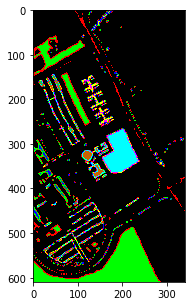

In [22]:
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = y,figsize =(5,5))

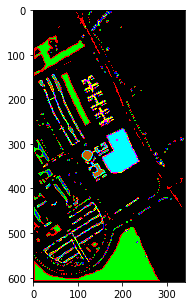

In [23]:
# Plot the Predicted image
outputs=generate_pridected_image()
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))